### Task 3: Build a model to predict booking cancellations. Include the model performance metrics in the presentation. ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from util.preprocessing import preprocess_data

In [2]:
# loading the raw dataset
df = pd.read_csv('data/hotels.csv')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [3]:
x,y = preprocess_data(df)

All columns handled.
(118898, 244) (118898,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)

#### Model selection: ####

A couple models commonly used for binary classification are tested (Logistic Regression, Support Vector Machine, Random Forest, XGBoost, and LGBM classifiers). The models are compared based on base f1-score (performance without optimization), and training time.

In [187]:
models = {'Logistic_regression': LogisticRegression(solver='sag'),
        'Support_vector_machine': SVC(),
        'Random_forest': RandomForestClassifier(),
        'XG_boost': XGBClassifier(),
        'LGBM': LGBMClassifier(force_row_wise=True)
}

traintimes = pd.DataFrame(columns=['name','f1-score','train time [s]'])
for model_name in models:
    model = models[model_name]
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    traintimes.loc[len(traintimes)] = (model_name, f1_score(y_test, y_pred).round(5), train_time)
traintimes

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33012, number of negative: 56161
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 89173, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370202 -> initscore=-0.531351
[LightGBM] [Info] Start training from score -0.531351


,name,f1-score,train time [s]
0,Logistic_regression,0.72374,3.543764
1,Support_vector_machine,0.77948,793.938008
2,Random_forest,0.84037,18.651448
3,XG_boost,0.82143,0.899506
4,LGBM,0.81187,0.449679


As the results above show, Random Forest, XGBoost, and LGBM provide the best scores. However, even though Random Forest's scores are the highest, it's training time is so high compared to the models using gradient boosting, that I ended up selecting the **XGBoost** model for further training.

#### Model optimization: ####
1. A couple of values for a set of parameters are selected over a broad range. The model is optimized for f1-score.
2. After a rough range is determined for the parameters in questions, a second hyperparameter search is ran, over narrower grid
3. Evaluating each metric (F1-score, AUC, Accuracy, Precision, Recall) for the optimized model.
4. Finally, the confusion-matrix and the ROC curve are also drawn 

In [73]:
# a scorer is needed to check f1-score
f1score = make_scorer(f1_score , average='macro')

# a dictionary is required for GridSearch to be able to calculate multiple scores
scores = {'f1-score': f1score,
        'AUC-score': 'roc_auc',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall'
}

# model of choice is XGBoost
estimator = [('clf', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=estimator)

# parameter set for training Random Forest Classifier
params = {'clf__bootstrap': [True, False],
        'clf__max_depth': [10, 20, None],
        'clf__max_features': ['auto', 'sqrt'],
        'clf__min_samples_leaf': [1, 2],
        'clf__min_samples_split': [2, 5],
        'clf__n_estimators': [200, 400]}

# parameter set for initial training of XGBoost Classifier
params = {'clf__max_depth': [2, 8, 20],
        'clf__learning_rate': [10, 20, None],
        'clf__subsample': [1, 1.5],
        'clf__colsample_bytree': [0.5, 1],
        'clf__colsample_bylevel': [0.5, 1],
        'clf__colsample_bynode': [0.5, 1],
        'clf__reg_alpha': [0, 10],
        'clf__reg_lambda': [0, 10],
        'clf__gamma': [0, 10]
        }

# parameter set of finetuning XGBoost Classifier
params = {'clf__max_depth': [20, 30, 40],
        'clf__learning_rate': [None],
        'clf__subsample': [0.5, 1],
        'clf__colsample_bytree': [0.5],
        'clf__colsample_bylevel': [1],
        'clf__colsample_bynode': [1],
        'clf__reg_alpha': [0, 2],
        'clf__reg_lambda': [0, 2],
        'clf__gamma': [0]
        }

# resulting parameter set of hyperparameter tuning
params = {'clf__max_depth': [20],
        'clf__learning_rate': [None],
        'clf__subsample': [1],
        'clf__colsample_bytree': [0.5],
        'clf__colsample_bylevel': [1],
        'clf__colsample_bynode': [1],
        'clf__reg_alpha': [0],
        'clf__reg_lambda': [2],
        'clf__gamma': [0]
        }

In [128]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__objective', 'clf__base_score', 'clf__booster', 'clf__callbacks', 'clf__colsample_bylevel', 'clf__colsample_bynode', 'clf__colsample_bytree', 'clf__device', 'clf__early_stopping_rounds', 'clf__enable_categorical', 'clf__eval_metric', 'clf__feature_types', 'clf__gamma', 'clf__grow_policy', 'clf__importance_type', 'clf__interaction_constraints', 'clf__learning_rate', 'clf__max_bin', 'clf__max_cat_threshold', 'clf__max_cat_to_onehot', 'clf__max_delta_step', 'clf__max_depth', 'clf__max_leaves', 'clf__min_child_weight', 'clf__missing', 'clf__monotone_constraints', 'clf__multi_strategy', 'clf__n_estimators', 'clf__n_jobs', 'clf__num_parallel_tree', 'clf__random_state', 'clf__reg_alpha', 'clf__reg_lambda', 'clf__sampling_method', 'clf__scale_pos_weight', 'clf__subsample', 'clf__tree_method', 'clf__validate_parameters', 'clf__verbosity'])

In [225]:
### This section is ran multiple times, with different 'params' dictionaries. First we narrow down the range of each hyperparameter from a larger scale. Then the parameters are tuned further to a finer distribution over a smaller scale.

# The model is optimized for f1-score. 5-fold cross-validation is used during training.
grid_search = GridSearchCV(pipeline, params, cv=5, scoring=scores, refit='f1-score')
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_

# model_opt is model with a singular set of parameters, which are optimal according to the previously ran GridSearch.
model_opt = GridSearchCV(estimator=best_estimator, param_grid={}, cv=5, scoring=scores, refit='f1-score')
model_opt.fit(X_train, y_train)
model_opt.best_score_

0.8753734442663088

In [226]:
### metrics for the optimized model are displayed:
results = model_opt.cv_results_
auc = results['mean_test_AUC-score'][0]
accuracy = results['mean_test_accuracy'][0]
precision = results['mean_test_precision'][0]
recall = results['mean_test_recall'][0]
f1 = results['mean_test_f1-score'][0]
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('f1-score: {}'.format(f1))
print('AUC-score: {}'.format(auc))

Accuracy: 0.8852679869634736
Precision: 0.8670282788550537
Recall: 0.8150975135782103
f1-score: 0.8753734442663088
AUC-score: 0.9539159660687838


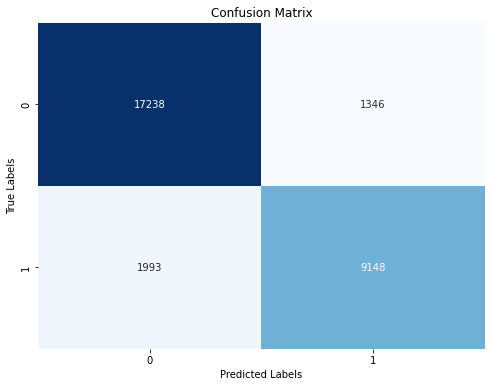

In [227]:
### Confusion matrix of the model is calculated and displayed

#
y_pred = best_estimator.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

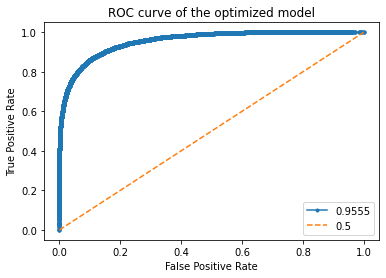

In [235]:
### Receiver Operating Characteristic (ROC) curve of the model is displayed

# probabilities corresponding to X_test (y_pred_proba) are required to plot the ROC curve
y_pred_proba = best_estimator.predict_proba(X_test)
y_pred_1 = y_pred_proba[:,1]

lr_auc = roc_auc_score(y_test, y_pred_1).round(4)
ns_probs = [0 for _ in range(len(y_test))]

# False Positive Rate and True Positive Rate of the prediction are calculated and plotted:
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_1)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label=lr_auc)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve of the optimized model')
plt.show()